**GENERAL THOUGHTS:**
- ...


**DATA PREPROCESSING:**

Imbalanced data:
- over_sampling for imbalanced data
- cost-sensitive learning for imbalanced data

categorical data:
- Ordinal Data: The categories have an inherent order
- Nominal Data: The categories do not have an inherent order



**MULTI-CLASS CLASSIFIER:**
- Focus on "Native Multiclass Classifiers" as a starting point. Might try "Binary Transformation" or "Hierarchical Classification" later. https://www.projectpro.io/article/multi-class-classification-python-example/547
- Overview models to be considered:  
  - [X] Decision Trees

In [1]:
import os
import pickle
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sklearn
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_sample_weight

from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import xgboost as xgb
# import lightgbm as lgbm

# import optuna
# from optuna.samplers import TPESampler

import imblearn
from imblearn.over_sampling import RandomOverSampler

# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform

# import custom functions
import sys
sys.path.append('/Users/dat/Library/CloudStorage/OneDrive-foryouandyourcustomers/GitHub/AutomatedPackagingCategories_Showcase/ml_packaging_classification/src')
import utils


In [4]:
SEED = 42

clf_name = "best_clf"

# Get current date and time
now = datetime.now()
# Format date and time
formatted_date_time = now.strftime("%Y-%m-%d_%H:%M:%S")
print(formatted_date_time)

2023-08-08_14:28:25


# Load data

In [5]:
df = pd.read_csv('../../data/output/df_ml.csv', sep='\t')

# Prep data for machine learning

In [6]:
df['material_number'] = df['material_number'].astype('object')

df_sub = df[[
    'material_number',
    'brand',
    'product_area',
    'core_segment',
    'component',
    'manufactoring_location',
    'characteristic_value',
    'material_weight', 
    'packaging_code',
    'packaging_category',
]]

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82977 entries, 0 to 82976
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   material_number         82977 non-null  object 
 1   material_number_text    82977 non-null  object 
 2   brand                   82977 non-null  object 
 3   product_area            82977 non-null  object 
 4   core_segment            82977 non-null  object 
 5   component               82977 non-null  object 
 6   component_text          82977 non-null  object 
 7   manufactoring_location  82977 non-null  object 
 8   characteristic_value    82977 non-null  object 
 9   material_weight         75913 non-null  float64
 10  packaging_code          82977 non-null  object 
 11  packaging_category      82977 non-null  object 
dtypes: float64(1), object(11)
memory usage: 7.6+ MB


In [7]:
# Define features and target
X = df_sub.iloc[:, :-1]
y = df_sub.iloc[:, -1]  # the last column is the target

In [8]:
distribution_classes = y.value_counts()
print('Class distribution before oversmapling')
print(distribution_classes.to_dict())

# NOTE: Oversampling so each class has at least 100 sample; to properly apply CV and evaluation
dict_oversmapling = {
    'Metal Cassette': 100,
    'Carton tube with or w/o': 100,
    'Wooden box': 100,
    'Fabric packaging': 100,
    'Book packaging': 100
}
# define oversampling strategy
oversampler = RandomOverSampler(sampling_strategy=dict_oversmapling, random_state=SEED)
# fit and apply the transform
X_oversample, y_oversample = oversampler.fit_resample(X, y)

distribution_classes = y_oversample.value_counts()
print('\n')
print('Class distribution after oversmapling')
print(distribution_classes.to_dict())

Class distribution before oversmapling
{'Hanger/ Clip': 13543, 'Tube': 11687, 'Blister and Insert Card': 8744, 'TightPack': 8296, 'Folding carton': 8219, 'Blister and sealed blist': 7912, 'Corrugated carton': 3872, 'Paperboard pouch': 3478, 'Trap Folding Card': 2188, 'Plastic Pouch': 1904, 'Plastic bag with header': 1850, 'Plastic Cassette': 1708, 'Shrink film and insert o': 1499, 'Plastic Box': 1491, 'Unpacked': 1415, 'Skincard': 1143, 'Trap Card': 804, 'Cardb. Sleeve w - w/o Shr.': 676, 'Carton cover (Lid box)': 652, 'Case': 485, 'Tray Packer': 431, 'Cardboard hanger w/o bag': 400, 'Envelope': 295, 'Countertop display': 150, 'Metal Cassette': 50, 'Carton tube with or w/o': 44, 'Wooden box': 16, 'Fabric packaging': 15, 'Book packaging': 10}


Class distribution after oversmapling
{'Hanger/ Clip': 13543, 'Tube': 11687, 'Blister and Insert Card': 8744, 'TightPack': 8296, 'Folding carton': 8219, 'Blister and sealed blist': 7912, 'Corrugated carton': 3872, 'Paperboard pouch': 3478, 'Trap 

In [9]:
# Generate train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_oversample, y_oversample, test_size=0.2, stratify=y_oversample,
    # random_state=SEED
)

# Best model pipeline

In [10]:
# DEFINE PIPELINE

# DEFINE PREPROCESSING PIPELINE
# define numerical feature processing
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
# print(f'There are {len(numerical_features)} numerical features:', '\n')
# print(numerical_features)
numeric_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('log_transform', PowerTransformer()),
    # ('scale', MinMaxScaler())
])
# define categorical feature processing
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()
# print(f'There are {len(categorical_features)} categorical features:', '\n')
# print(categorical_features)
categorical_feature_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    # ('one_hot', OneHotEncoder(handle_unknown='ignore', max_categories=None, sparse=False))
])
# apply both pipeline on seperate columns using "ColumnTransformer"
preprocess_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_feature_pipeline, numerical_features),
    ('category', categorical_feature_pipeline, categorical_features)
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

# DEFINE MODEL PIPELINE

label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
# y_train_transformed = label_ecoder.fit_transform(y_train)

# class_weights
# class_weights = compute_sample_weight(
#     class_weight='balanced',
#     y=y_train_transformed
# )
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_transformed),
    y=y_train_transformed
)
class_weight_dict = dict(enumerate(class_weights))

# model
best_params = {
    'n_estimators': 500,
    'max_depth': 20,
    'criterion': 'entropy'
}

best_model = RandomForestClassifier(
    class_weight=class_weight_dict,
    **best_params,
    # random_state=SEED
)

# Training
best_model.fit(X_train_transformed, y_train_transformed)

RandomForestClassifier(class_weight={0: 0.3286731902097557,
                                     1: 0.36320204826496705,
                                     2: 28.738362068965518,
                                     3: 4.249665370641851,
                                     4: 7.1845905172413795,
                                     5: 4.404346677236094,
                                     6: 28.738362068965518, 7: 5.92543547813722,
                                     8: 0.7421139333496583,
                                     9: 19.15890804597701,
                                     10: 9.741817650496786,
                                     11: 28.738362068965518,
                                     12: 0.349668283728858,
                                     13: 0.2122086916667197,
                                     14: 28.738362068965518,
                                     15: 0.8264086863829049,
                                     16: 1.9271324103245946,
                                     17: 1.6830665926187711,
                                     18: 1.5095659655398828,
                                     19: 1.5534249767008388,
                                     20: 1.9174887118575825,
                                     21: 2.5153927412661283,
                                     22: 0.34640183298436666,
                                     23: 3.5755349385960207,
                                     24: 1.3137536945812809,
                                     25: 6.663968015992004,
                                     26: 0.24588972893232527,
                                     27: 2.0309796515169976,
                                     28: 28.738362068965518},
                       criterion='entropy', max_depth=20, n_estimators=500)

In [11]:
# preprocess & make predictions for test data
X_test_transformed = preprocess_pipeline.transform(X_test)
preds_y_test_dt = best_model.predict(X_test_transformed)

y_test_transformed = label_encoder.transform(y_test)
preds_y_test_dt_inverse = label_encoder.inverse_transform(preds_y_test_dt)

# score the pipeline
print("Train score (f1-score): ", best_model.score(X_train_transformed, y_train_transformed))
print("Test score (f1-score): ", best_model.score(X_test_transformed, y_test_transformed))
print(classification_report(y_test, preds_y_test_dt_inverse))

Train score (f1-score):  0.9543443372879576
Test score (f1-score):  0.7945887575739397
                            precision    recall  f1-score   support

   Blister and Insert Card       0.76      0.82      0.79      1749
  Blister and sealed blist       0.77      0.75      0.76      1582
            Book packaging       0.95      1.00      0.98        20
Cardb. Sleeve w - w/o Shr.       0.54      0.47      0.50       135
  Cardboard hanger w/o bag       0.36      0.57      0.44        80
    Carton cover (Lid box)       0.49      0.52      0.51       130
   Carton tube with or w/o       0.68      0.75      0.71        20
                      Case       0.35      0.63      0.45        97
         Corrugated carton       0.79      0.74      0.77       774
        Countertop display       0.62      0.60      0.61        30
                  Envelope       0.87      0.88      0.87        59
          Fabric packaging       0.95      1.00      0.98        20
            Folding carton  

In [12]:
# Create df with y_test, preds_y_test & proba_preds_y_test 

# prediction
preds_y_test = best_model.predict(X_test_transformed)
preds_y_test_inverse = label_encoder.inverse_transform(preds_y_test)

# get proba of predicted class (determine max proba value from all classes per row)
preds_y_test = best_model.predict_proba(X_test_transformed)
df_proba = pd.DataFrame(preds_y_test, columns=best_model.classes_)
df_proba['predicted_class_proba'] = df_proba.max(axis=1)
proba_preds_y_test = df_proba['predicted_class_proba'].values

y_test_dict = {
    'y_test': y_test.to_numpy(),
    'preds_y_test': preds_y_test_inverse,
    'proba_preds_y_test': proba_preds_y_test,
}

df_y_test = pd.DataFrame(y_test_dict)
df_y_test.head(30)

,y_test,preds_y_test,proba_preds_y_test
0,Blister and Insert Card,Blister and Insert Card,0.687599
1,Folding carton,Folding carton,0.958885
2,Hanger/ Clip,Hanger/ Clip,0.972873
3,Blister and Insert Card,Blister and Insert Card,0.608860
4,TightPack,TightPack,0.996686
5,Blister and Insert Card,Blister and Insert Card,1.000000
6,Tube,Tube,0.968181
7,Hanger/ Clip,Hanger/ Clip,0.766466
8,Paperboard pouch,Paperboard pouch,0.884924
9,Tube,Tube,1.000000


# Business Decision Optimization

Learn to optimize decision rules, translating machine learning predictions into actionable insights. Discover how to achieve practical value and business impact by measuring performance using business metrics.  
- Translate Machine Learning Predictions Into Actionable Business Insights  
Identify decision and prediction problems and optimize them using advanced machine learning models.  
- Master Business Impact Measurement for ML Models  
Instead of relying solely on accuracy metrics, it is shown how to measure the performance of your ML models in business value terms. Discover the power of using profit curves for optimizing multi-class decisions, and uncover how to address their basic limitations.

Inspired by: https://github.com/wandb/edu/tree/main/decision-opt-course

<Figure size 1000x500 with 0 Axes>

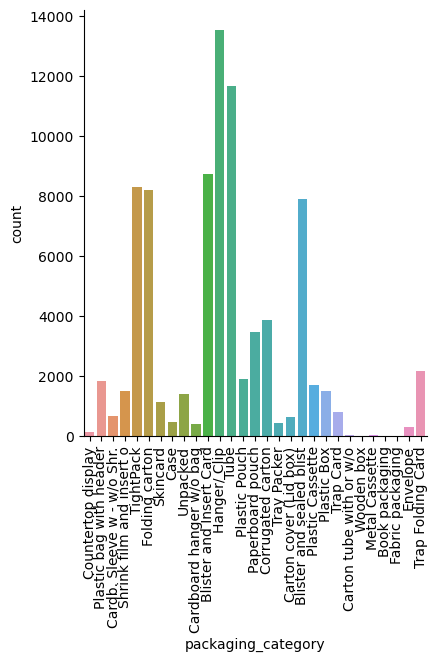

In [13]:
# class distribution (after oversampling)
plt.figure(figsize=(10,5))
cat_chart = sns.catplot(
    data=df_sub,
    x='packaging_category',
    kind='count',
)
cat_chart.set_xticklabels(rotation=90)

### Standard Confusion Matrix

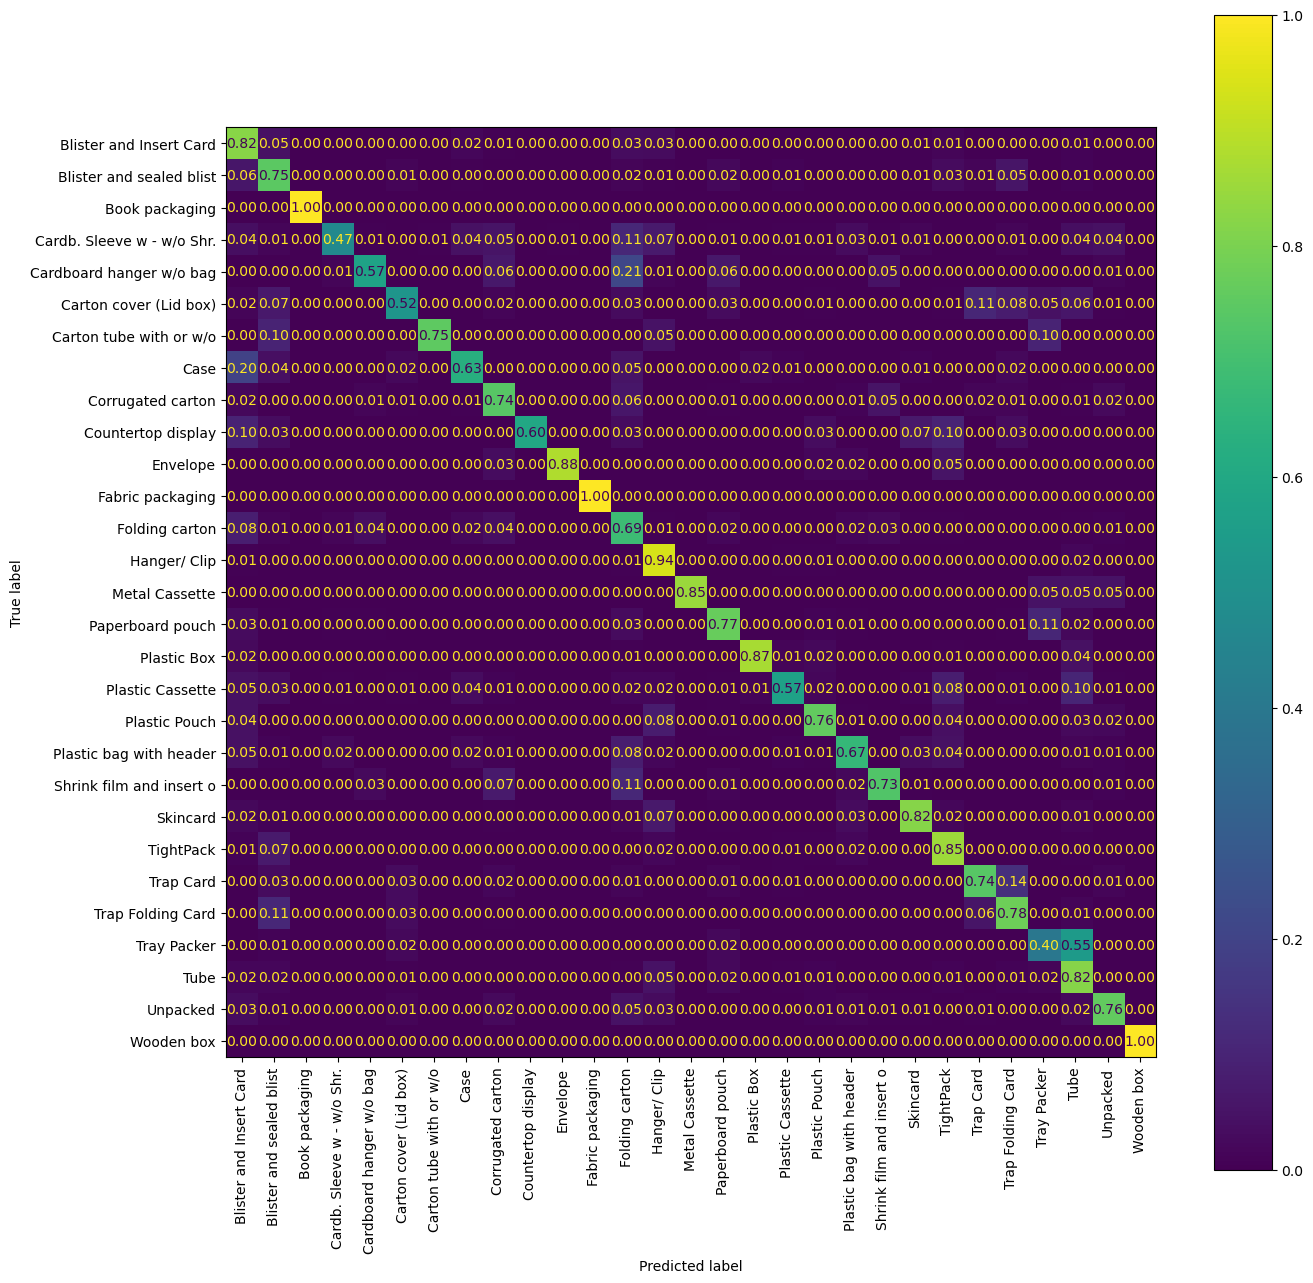

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test,
    y_pred=preds_y_test_inverse,
    normalize='true',
    values_format='.2f',
    ax=ax,
    xticks_rotation='vertical'
)

## Threshold analysis (since best model provides probabilistic forecasts)

A threshold analysis gives insights if we want to exclude specific packaging categories for which the model perfromance does not meet a threshold. The threshold used is based on the probability given by the model. The probability is calculated based on the persentage of correct predictions of the single trees within the random forest model.  
From a business perspective we might want to exclude categories to improve performance and ensure low classification errors with the cost of not providing predictions for the right packaging for some products. Wrong predictions have no or even a negative value and therefore might rather be approached manualy.  
The threshold analysis is used to determine an "optimal" threshold based on the ration between performance and product coverage. This is a great way to ensure specific perforance requirements are met. But it does not provide a cost (business) trade-off analysis, what we will do in the step after.

In [14]:
df_y_test.head()

,y_test,preds_y_test,proba_preds_y_test
0,Blister and Insert Card,Blister and Insert Card,0.687599
1,Folding carton,Folding carton,0.958885
2,Hanger/ Clip,Hanger/ Clip,0.972873
3,Blister and Insert Card,Blister and Insert Card,0.608860
4,TightPack,TightPack,0.996686


In [15]:
# threshhold None
# best_mode_clf_report = classification_report(df_y_test.y_test, df_y_test.preds_y_test, output_dict=True)
print(classification_report(df_y_test.y_test, df_y_test.preds_y_test))

                            precision    recall  f1-score   support

   Blister and Insert Card       0.76      0.82      0.79      1749
  Blister and sealed blist       0.77      0.75      0.76      1582
            Book packaging       0.95      1.00      0.98        20
Cardb. Sleeve w - w/o Shr.       0.54      0.47      0.50       135
  Cardboard hanger w/o bag       0.36      0.57      0.44        80
    Carton cover (Lid box)       0.49      0.52      0.51       130
   Carton tube with or w/o       0.68      0.75      0.71        20
                      Case       0.35      0.63      0.45        97
         Corrugated carton       0.79      0.74      0.77       774
        Countertop display       0.62      0.60      0.61        30
                  Envelope       0.87      0.88      0.87        59
          Fabric packaging       0.95      1.00      0.98        20
            Folding carton       0.78      0.69      0.73      1644
              Hanger/ Clip       0.89      0.94

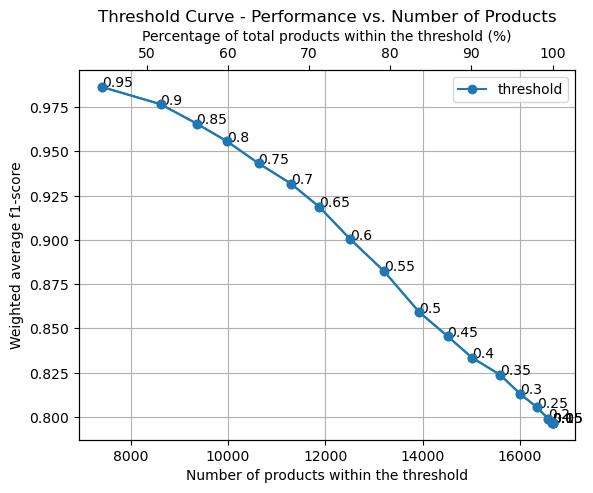

In [16]:
def threshold_analysis_f1(thresholds: list, df_y_test: pd.DataFrame):
    # TODO: add description
    # TODO: refactor function to make it usable for any metric within classification_report

    clf_reports = []

    for threshold in thresholds:
        df_y_test_threshold = df_y_test.loc[
            df_y_test.proba_preds_y_test >= threshold
        ]

        clf_report = classification_report(df_y_test_threshold.y_test, df_y_test_threshold.preds_y_test, output_dict=True)
        clf_reports.append(clf_report)

    f1_scores = []
    supports = []

    for j, clf_report in enumerate(clf_reports):
        f1_scores.append(clf_report['weighted avg']['f1-score'])
        supports.append(clf_report['weighted avg']['support'])

    fig, ax1 = plt.subplots()
    ax2 = ax1.twiny()  # Create a twin x-axis that shares the y-axis with ax1

    ax1.plot(supports, f1_scores, 'o-', label='threshold')
    for i, txt in enumerate(thresholds):
        ax1.annotate(txt, (supports[i], f1_scores[i])) 

    # New x-axis for percentage of products
    ax2.plot([x / len(df_y_test)*100 for x in supports], f1_scores, 'o-')  # Note the transformation of supports to %

    ax1.legend()
    ax1.grid()
    ax1.set_title('Threshold Curve - Performance vs. Number of Products')
    ax1.set_xlabel('Number of products within the threshold')
    ax2.set_xlabel('Percentage of total products within the threshold (%)')
    ax1.set_ylabel('Weighted average f1-score')

    plt.show()

    return clf_reports

# thresholds = [0, 0.80, 0.85, 0.90, 0.95]
thresholds = np.round(np.arange(0, 1.00, 0.05), 2)

clf_reports = threshold_analysis_f1(thresholds=thresholds, df_y_test=df_y_test)


In [17]:
# NOTE: Matplotlib code cariation: plt. instead of fig./ax.

# def threshold_analysis(thresholds: list, df_y_test: pd.DataFrame):

#     # calculate individual clf reports for the data (subset of packaging categories) that fulfill the threshold condition
#     clf_reports = []

#     for threshold in thresholds:
#         df_y_test_threshold = df_y_test.loc[
#             df_y_test.proba_preds_y_test >= threshold
#         ]

#         clf_report = classification_report(df_y_test_threshold.y_test, df_y_test_threshold.preds_y_test, output_dict=True)
#         clf_reports.append(clf_report)

#     # plot threshold curve
#     f1_scores = []
#     supports = []

#     for j, clf_report in enumerate(clf_reports):
#         f1_scores.append(clf_report['weighted avg']['f1-score'])
#         supports.append(clf_report['weighted avg']['support'])

#     plt.plot(supports, f1_scores, 'o-', label='threshold')
#     for i, txt in enumerate(thresholds):
#         plt.annotate(txt, (supports[i], f1_scores[i])) # Adding the annotation
#     plt.legend()
#     plt.grid()
#     plt.title('Threshold Curve - Perfermance vs. Number of Products')
#     plt.xlabel('Number of products within the threshold')
#     plt.ylabel('weighted average f1-score')
#     plt.show()
    
#     return clf_reports


# # thresholds = [0, 0.80, 0.85, 0.90, 0.95]
# thresholds = np.round(np.arange(0, 1.00, 0.05), 2)

# clf_reports = threshold_analysis(thresholds=thresholds, df_y_test=df_y_test)

## Cost trade-off anaylsis (business perspective)

In the previous step we introduced a threshold analysis to determine an "optimal" threshold based on the ration between performance and product coverage.  
In the next step we will add a payoff-metrix that reflects business costs of "true" and "false" predictions, as well as individual class weights. By doing so we are able to assesses the business value/cost behind the performance on an individual class (package categoriy) importance (value).

### Define class categories into 3 importance groups

In [19]:
first_level_categories = [
    'Blister and Insert Card',
    'Hanger/ Clip',
    'Plastic Cassette',
    'Tube',
    'Blister and sealed blist',
    'Case',
    'TightPack',
    'Shrink film and insert o',
    'Plastic Pouch',
    'Plastic Box',
    'Plastic bag with header',
    'Skincard',
]

second_level_categories = [
    'Cardb. Sleeve w - w/o Shr.', 
    'Folding carton', 
    'Unpacked', 
    'Cardboard hanger w/o bag',
    'Paperboard pouch',
    'Corrugated carton', 
    'Tray Packer',
    'Carton cover (Lid box)', 
    'Trap Card',
    'Carton tube with or w/o', 
    'Wooden box',
    'Metal Cassette', 
    'Book packaging', 
    'Fabric packaging',
    'Envelope', 
    'Trap Folding Card'
]

# create subset based on most categorie importance
print('shape df_sub: ', df_sub.shape)
df_first_level = df_sub.loc[df_sub.packaging_category.isin(first_level_categories)]
print('shape df_first_level: ', df_first_level.shape)
df_second_level = df_sub.loc[df_sub.packaging_category.isin(second_level_categories)]
print('shape df_second_level: ', df_second_level.shape)
df_third_level = df_sub.loc[
    (~df_sub.packaging_category.isin(first_level_categories)) &
    (~df_sub.packaging_category.isin(second_level_categories))
]
print('shape df_third_level: ', df_third_level.shape)
print('Shapes are consistant: ', df_sub.shape[0] == df_first_level.shape[0] + df_second_level.shape[0] + df_third_level.shape[0])
third_level_categories = list(df_third_level.packaging_category.unique())

shape df_sub:  (82977, 10)
shape df_first_level:  (60262, 10)
shape df_second_level:  (22565, 10)
shape df_third_level:  (150, 10)
Shapes are consistant:  True


### Define payoff-matrix with consideration of each importance group

The payoff-matrix reflects the cost behind our packaging classification task. In this case the costs relfects a combination of time-effort and financial costs. Those cost might be different for TP, FP, TN and FN and therefore need to be defined for each class indipendently, which results on a payoff-matrix for each class.    
To simplify the payoff-matrix for multi-class classification we assume the following:
- We only distinguish between TP, FN, FP and TN but do not consider single classes
- Cost matrix is defined as as [[1, 30], [50, 1]] and relates to the format [[TP, FN], [FP, TN]]
- Class importance is reflected in a cost-factor for each importance group:
  - first_level_categories cost-factor: 1
  - second_level_categories cost-factor: 2
  - third_level_categories cost-factor: 3

In [22]:
# define class weights
dict_first_lvl_weights = {key: 1 for key in first_level_categories}
dict_second_lvl_weights = {key: 2 for key in second_level_categories}
dict_third_lvl_weights = {key: 3 for key in third_level_categories}
class_weights_dict = dict_first_lvl_weights | dict_second_lvl_weights | dict_third_lvl_weights

# prep inputs to calc business costs
cm_sub = confusion_matrix(y_test, preds_y_test_inverse, labels=np.sort(df_sub.packaging_category.unique()))
cost_matrix = np.array([[1, -3], [-5, 1]])    # [[TP, FN], [FP, TN]]
class_weights = dict(sorted(class_weights_dict.items()))

# cost_macro = utils.calculate_weighted_cost(cm_sub, cost_matrix, method='macro')
cost_weighted = utils.calculate_weighted_cost(cm_sub, cost_matrix, method='weighted', class_weights=class_weights) # class_weights must be in the same order as the labels used in the confusion matrix.
# cost_micro = utils.calculate_weighted_cost(cm_sub, cost_matrix, method='micro')

# print("Macro-averaged cost: ", cost_macro)
print("Weighted-averaged cost: ", cost_weighted)
# print("Micro-averaged cost: ", cost_micro)

Weighted-averaged cost:  735917


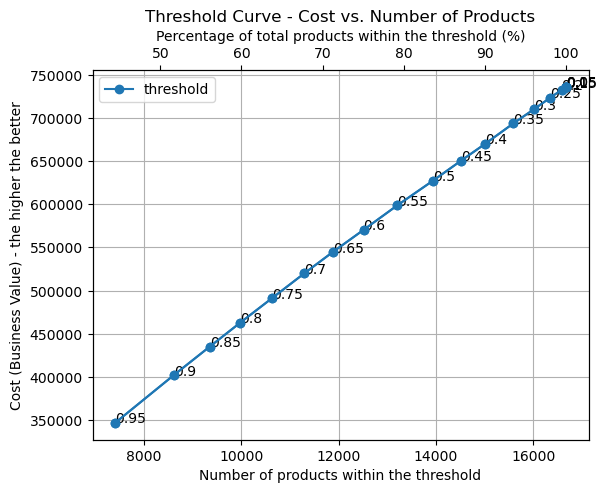

In [27]:
def threshold_analysis_cost(thresholds: list, df_y_test: pd.DataFrame, unique_classes: list = None):

    costs = []
    supports = []

    for threshold in thresholds:
        df_y_test_threshold = df_y_test.loc[
            df_y_test.proba_preds_y_test >= threshold
        ]

        # define class weights
        dict_first_lvl_weights = {key: 1 for key in first_level_categories}
        dict_second_lvl_weights = {key: 2 for key in second_level_categories}
        dict_third_lvl_weights = {key: 3 for key in third_level_categories}
        class_weights_dict = dict_first_lvl_weights | dict_second_lvl_weights | dict_third_lvl_weights

        # prep inputs to calc business costs
        cm_sub = confusion_matrix(df_y_test_threshold['y_test'], df_y_test_threshold['preds_y_test'], labels=np.sort(unique_classes))
        cost_matrix = np.array([[1, -3], [-5, 1]])    # [[TP, FN], [FP, TN]]
        class_weights = dict(sorted(class_weights_dict.items()))

        cost = utils.calculate_weighted_cost(cm_sub, cost_matrix, method='weighted', class_weights=class_weights) # class_weights must be in the same order as the labels used in the confusion matrix.
        costs.append(cost)

        support = df_y_test_threshold.shape[0]
        supports.append(support)



    fig, ax1 = plt.subplots()
    ax2 = ax1.twiny()  # Create a twin x-axis that shares the y-axis with ax1

    ax1.plot(supports, costs, 'o-', label='threshold')
    for i, txt in enumerate(thresholds):
        ax1.annotate(txt, (supports[i], costs[i])) 

    # New x-axis for percentage of products
    ax2.plot([x / len(df_y_test)*100 for x in supports], costs, 'o-')  # Note the transformation of supports to %

    ax1.legend()
    ax1.grid()
    ax1.set_title('Threshold Curve - Value/Cost vs. Number of Products')
    ax1.set_xlabel('Number of products within the threshold')
    ax2.set_xlabel('Percentage of total products within the threshold (%)')
    ax1.set_ylabel('Business Value - the higher the better')

    plt.show()

    return

# thresholds = [0, 0.80, 0.85, 0.90, 0.95]
thresholds = np.round(np.arange(0, 1.00, 0.05), 2)

threshold_analysis_cost(thresholds=thresholds, df_y_test=df_y_test, unique_classes=df_sub['packaging_category'].unique())
